In [1]:
import pandas as pd
# 두 단계 밖으로 나갔다가 data 폴더로 들어가는 경로
customer = pd.read_csv('../../data/customer_hm.csv') 
transactions = pd.read_csv('../../data/transactions_hm.csv')
articles = pd.read_csv('../../data/articles_hm.csv')

#원본 데이터 지키기 위해서 copy
df_cust = customer.copy()
df_tran = transactions.copy()
df_art = articles.copy()


###customer 데이터 전처리###
#고객 테이블 결측치 확인
df_cust.isnull().sum()

# fashion_news_frequency가 결측치인 데이터만 추출
missing_data = df_cust[df_cust['fashion_news_frequency'].isnull()]
missing_data

# FN이 1이고, Active가 0인 fashion_news_frequency의 고유값별 빈도 확인
df_cust[(df_cust['FN'] == 1) & (df_cust['Active'] == 0)
]['fashion_news_frequency'].value_counts(dropna=False)

# 결측치 'Regularly'으로 채우기
df_cust['fashion_news_frequency'] = df_cust['fashion_news_frequency'].fillna('Regularly')

#  (문자형 정수형으로 매핑) 사전 정의
status_map = {'ACTIVE': 2, 'PRE-CREATE': 1, 'LEFT CLUB': 0}
frequency_map = {'Regularly': 2, 'Monthly': 1, 'NONE': 0}

#  매핑 적용
df_cust['club_member_status'] = df_cust['club_member_status'].map(status_map)
df_cust['fashion_news_frequency'] = df_cust['fashion_news_frequency'].map(frequency_map)


# 나이를 나이대별로 나눠 파생변수 생성
def cate_age(age):
    if age < 20: return '10대'
    elif age < 30: return '20대'
    elif age < 40: return '30대'
    elif age < 50: return '40대'
    elif age < 60: return'50대'
    else: return '60대 이상'

df_cust['age_segment'] = df_cust['age'].apply(cate_age)


###transactions 데이터 전처리###

#join을 위해 동일한 타입으로 변환
df_tran['customer_id']= df_tran['customer_id'].astype(str)
df_cust['customer_id']= df_cust['customer_id'].astype(str)

df_tran['article_id']= df_tran['article_id'].astype(str).str.zfill(10)

#데이터 크기 및 중복 확인

print("df_tran (복사본) 크기:", df_tran.shape)
print("중복 데이터 수:", df_tran.duplicated().sum())

#중복된 거래 로그를 제거하여 분석 결과의 왜곡을 방지
df_tran.drop_duplicates(inplace=True)

# 날짜 타입 변환
df_tran['t_dat'] = pd.to_datetime(df_tran['t_dat'], format='%Y-%m-%d')

# 판매 채널 컬럼 생성 및 값 변환
df_tran["channel"] = df_tran["sales_channel_id"].map({1: "오프라인", 2: "온라인"})
df_tran["channel"].value_counts() 
numbs = df_tran["channel"].value_counts()
print("온라인:", f"{numbs['온라인']:,}")
print("오프라인:", f"{numbs['오프라인']:,}")
print("전체 거래 건수:", f"{df_tran.shape[0]:,}")


# 가격 데이터 분포 확인
df_tran['price'].describe() 
print("price가 0.1 이상:", len(df_tran[df_tran["price"] >= 0.1]))
print("price가 0.2 이상:", len(df_tran[df_tran["price"] >= 0.2]))
print("price가 0.3 이상:", len(df_tran[df_tran["price"] >= 0.3]))
print("price가 0.4 이상:", len(df_tran[df_tran["price"] >= 0.4]))
print("price가 0.5 이상:", len(df_tran[df_tran["price"] >= 0.5]))

#고가 거래 분리 및 채널 확인
high_price_transactions = df_tran[df_tran["price"] >= 0.4]
high_price_transactions['sales_channel_id'].replace({1: 'Offline', 2: 'Online'}).value_counts() 

#월 컬럼 생성
df_tran['year_month'] = df_tran['t_dat'].dt.to_period('M') 

#월별 거래 건수 & 매출액 계산
monthly_sales = df_tran.groupby('year_month').size()
monthly_price = df_tran.groupby('year_month')['price'].sum()

print(monthly_price)

# 최고 매출 월 
best_month = monthly_price.idxmax()
best_value = monthly_price.max()

print("가장 매출이 높은 달:", best_month)
print("그 달의 매출:", best_value) 


###article 데이터 전처리###

# 1. ID 형식 통일 (다른 테이블과 과정 동일해야함. 회의 때 의견 통일)
# article_id를 10자리 문자열로 변환하여 앞의 '0'이 잘리지 않게
df_art['article_id'] = df_art['article_id'].astype(str).str.zfill(10)

# 2. 결측치(NULL) 제어 (detail_desc의 NULL값을 No Description로)
df_art['detail_desc'] = df_art['detail_desc'].fillna('No Description')

# 3. 불필요 컬럼 제거 (메모리 줄이기)
# Name(이름)이 존재하여 중복 정보인 Code(코드성 숫자) 컬럼 불필요함. 제거!
cols_to_drop = [
    'product_type_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'index_group_no',
    'section_no',
    'garment_group_no'
]
df_art_cleaned = df_art.drop(columns=cols_to_drop) 

# 매핑 및 파생변수 설정 (시즌별 / 고관여&저관여 / 신상품 여부 / 색감 여부)
# 1. 시즌 별 매핑 (product_season) / 시즌성 구분을 위한 키워드 정의
def get_season(section):
    section = section.lower()
    # FW
    if any(kw in section for kw in ['outerwear', 'nightwear', 'socks', 'tights', 'knitted']):
        return 'FW'
    # SS
    elif any(kw in section for kw in ['swimwear', 'sport', 'shorts', 'sandals']):
        return 'SS'
    # 두루두루 아이템(all season)
    else:
        return 'All-Season'

#파생변수 생성 및 이름만 조금 더 직관적으로 분류
df_art_cleaned['product_season'] = df_art_cleaned['section_name'].apply(get_season)
df_art_cleaned['category_main'] = df_art_cleaned['index_group_name']    #원본 보존하고 복사해서 이름 변경 (메인 카테고리 정의)


# 2. 저관여/고관여 제품 분류?
def get_involvement_strategy(row):
    garment = str(row['garment_group_name']).lower()
    section = str(row['section_name']).lower()
    
    # 1. 저관여 (베이직)
    if any(kw in garment for kw in ['basic', 'underwear', 'socks', 'jersey']) or \
       'basic' in section:
        return 'Low_Involvement_Basic'
    
    # 2. 고관여 (전략템/트렌드템)
    elif any(kw in garment for kw in ['knitwear', 'outerwear', 'dresses']) or \
         any(kw in section for kw in ['trend', 'special']):
        return 'High_Involvement_Strategic'
    
    else:
        return 'General_Fashion'
# 파생변수 생성
df_art_cleaned['product_strategy'] = df_art_cleaned.apply(get_involvement_strategy, axis=1)
display(df_art_cleaned[['article_id', 'prod_name', 'product_strategy']].head()) #확인용


# 3. 신상품/트렌드 여부 파생변수
def check_newness(row):
    text = (str(row['prod_name']) + " " + str(row['detail_desc'])).lower()
    new_keywords = ['new', 'collection', 'latest', 'trend', 'exclusive']
    
    if any(kw in text for kw in new_keywords):
        return 'New_Arrival'
    return 'Regular_Carryover'
# 파생변수 생성
df_art_cleaned['is_new'] = df_art_cleaned.apply(check_newness, axis=1)

# 4. 색상 톤 그룹화 
def get_color_tone(color):
    color = str(color).lower()
    dark_colors = ['black', 'dark blue', 'dark grey', 'dark red', 'navy blue', 'dark green', 'anthracite']
    light_colors = ['white', 'light beige', 'off white', 'light pink', 'light blue', 'yellowish brown']
    
    if any(dc in color for dc in dark_colors):
        return 'Dark_Tone'
    elif any(lc in color for lc in light_colors):
        return 'Light_Tone'
    else:
        return 'Neutral_Tone'
# 파생변수 생성
df_art_cleaned['color_tone'] = df_art_cleaned['colour_group_name'].apply(get_color_tone)

df_tran (복사본) 크기: (1048575, 5)
중복 데이터 수: 8474
온라인: 721,488
오프라인: 318,613
전체 거래 건수: 1,040,101
price가 0.1 이상: 10704
price가 0.2 이상: 719
price가 0.3 이상: 126
price가 0.4 이상: 29
price가 0.5 이상: 2
year_month
2019-01    2129.926131
2019-02    1989.217641
2019-03    2374.905504
2019-04    2703.443538
2019-05    2748.199469
2019-06    3088.776976
2019-07    2552.035334
2019-08    1943.422489
2019-09    2559.226862
2019-10    2358.486793
2019-11    2463.769270
2019-12    1985.492149
Freq: M, Name: price, dtype: float64
가장 매출이 높은 달: 2019-06
그 달의 매출: 3088.776976142


,article_id,prod_name,product_strategy
0,0108775015,Strap top,Low_Involvement_Basic
1,0108775044,Strap top,Low_Involvement_Basic
2,0108775051,Strap top (1),Low_Involvement_Basic
3,0110065001,OP T-shirt (Idro),General_Fashion
4,0110065002,OP T-shirt (Idro),General_Fashion


In [3]:
#  첫 번째 조인: 거래 + 고객 (customer_id 기준)
merged_df = pd.merge(df_tran, df_cust, on='customer_id', how='left')

# 두 번째 조인: (거래+고객) + 상품 (article_id 기준)
final_df = pd.merge(merged_df, df_art_cleaned, on='article_id', how='left')

# 결과 확인
print(f"최종 병합 데이터 크기: {final_df.shape}")
final_df.head()

최종 병합 데이터 크기: (1040101, 32)


,t_dat,customer_id,article_id,price,sales_channel_id,channel,year_month,FN,Active,club_member_status,...,index_name,index_group_name,section_name,garment_group_name,detail_desc,product_season,category_main,product_strategy,is_new,color_tone
0,2019-11-05,3e2b60b679e62fb49516105b975560082922011dd752ec...,0698328010,0.016932,2,온라인,2019-11,1.0,1.0,2.0,...,Divided,Divided,Divided Collection,Jersey Fancy,Top in lightweight sweatshirt fabric with drop...,All-Season,Divided,Low_Involvement_Basic,Regular_Carryover,Dark_Tone
1,2019-05-22,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,0760597002,0.033881,2,온라인,2019-05,0.0,0.0,2.0,...,Ladieswear,Ladieswear,Womens Casual,Jersey Fancy,"Short-sleeved blouse in stretch, textured jers...",All-Season,Ladieswear,Low_Involvement_Basic,Regular_Carryover,Light_Tone
2,2019-05-10,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,0488561032,0.016932,2,온라인,2019-05,1.0,1.0,2.0,...,Menswear,Menswear,Contemporary Casual,Shorts,Knee-length shorts in soft washed cotton with ...,All-Season,Menswear,General_Fashion,Regular_Carryover,Dark_Tone
3,2019-08-26,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,0682771001,0.033881,2,온라인,2019-08,0.0,0.0,2.0,...,Ladies Accessories,Ladieswear,Womens Big accessories,Accessories,Shopper in grained imitation leather with two ...,All-Season,Ladieswear,General_Fashion,Regular_Carryover,Dark_Tone
4,2019-08-10,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,0742400033,0.003220,1,오프라인,2019-08,0.0,0.0,2.0,...,Menswear,Menswear,Men Underwear,Socks and Tights,"Socks in a soft, fine-knit cotton blend with r...",All-Season,Menswear,Low_Involvement_Basic,Regular_Carryover,Light_Tone


In [4]:
final_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1040101 entries, 0 to 1040100
Data columns (total 32 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   t_dat                         1040101 non-null  datetime64[us]
 1   customer_id                   1040101 non-null  str           
 2   article_id                    1040101 non-null  str           
 3   price                         1040101 non-null  float64       
 4   sales_channel_id              1040101 non-null  int64         
 5   channel                       1040101 non-null  str           
 6   year_month                    1040101 non-null  period[M]     
 7   FN                            806367 non-null   float64       
 8   Active                        806367 non-null   float64       
 9   club_member_status            806367 non-null   float64       
 10  fashion_news_frequency        806367 non-null   float64       
 11  age      

In [5]:
final_df.isnull().sum()

t_dat                                0
customer_id                          0
article_id                           0
price                                0
sales_channel_id                     0
channel                              0
year_month                           0
FN                              233734
Active                          233734
club_member_status              233734
fashion_news_frequency          233734
age                             233734
age_segment                     233734
product_code                         0
prod_name                            0
product_type_name                    0
product_group_name                   0
graphical_appearance_name            0
colour_group_name                    0
perceived_colour_value_name          0
perceived_colour_master_name         0
department_name                      0
index_name                           0
index_group_name                     0
section_name                         0
garment_group_name       

In [17]:
# 1. 연령대(age_segment)의 결측치를 'Unknown'으로 채우기
final_df['age_segment'] = final_df['age_segment'].fillna('Unknown')

# 2. 고객 상태(club_member_status)의 결측치를 'Unknown'으로 채우기
final_df['club_member_status'] = final_df['club_member_status'].fillna('Unknown')

final_df['FN'] = final_df['FN'].fillna('Unknown')

final_df['Active'] = final_df['Active'].fillna('Unknown')

final_df['fashion_news_frequency'] = final_df['fashion_news_frequency'].fillna('Unknown')

final_df['age'] = final_df['age'].fillna('Unknown')

# 결측치가 잘 채워졌는지 확인
print(final_df['age_segment'].value_counts())

age_segment
20대        329534
Unknown    233734
30대        164457
50대        135167
40대        125774
60대 이상      37794
10대         13641
Name: count, dtype: int64


In [27]:
# 연령대별 구매 채널 비중 분석
final_df['age_segment'].value_counts(normalize=True)*100

age_segment
20대        31.682885
Unknown    22.472241
30대        15.811638
50대        12.995565
40대        12.092479
60대 이상      3.633686
10대         1.311507
Name: proportion, dtype: float64

In [ ]:
#  연령대가 'Unknown'인 데이터만 필터링
df_unknown = final_df[final_df['age_segment'] == 'Unknown']

# 온·오프라인(sales_channel_id) 비중 산출
unknown_channel_ratio = df_unknown['sales_channel_id'].value_counts(normalize=True) * 100

#  결과 출력 (1: 오프라인, 2: 온라인)
print("### 'Unknown' 고객의 전체 구매 채널 비중 ###")
print(f"오프라인(1) 비중: {unknown_channel_ratio.get(1, 0):.1f}%")
print(f"온라인(2) 비중: {unknown_channel_ratio.get(2, 0):.1f}%")

### 'Unknown' 고객의 전체 구매 채널 비중 ###
오프라인(1) 비중: 30.7%
온라인(2) 비중: 69.3%


Unknown 고객의 69%가 온라인에서 발생하고 있음
왜 비회원으로 구매할까?

In [21]:
# 구매 경로별 연령대 비율

# 구매 경로(sales_channel_id)와 연령대(age_segment) 간의 교차표 생성
# normalize='index'를 사용하여 각 경로별 합계를 100%로 만듭니다.
channel_age_ratio = pd.crosstab(final_df['channel'], 
                                final_df['age_segment'], 
                                normalize='index') * 100


print(channel_age_ratio.round(1))

age_segment  10대   20대   30대   40대   50대  60대 이상  Unknown
channel                                                  
오프라인         1.8  31.0  12.9  13.1  14.4     4.3     22.5
온라인          1.1  32.0  17.1  11.6  12.4     3.4     22.4


온라인, 오프라인의 연령대별 비율이 전체적으로 비슷하다.
20대,30대는 온라인 비율이 더 높다.
10대,40대,50대,60대이상은 오프라인 비율이 더 높다.

온라인, 오프라인 모두 20대 비중이 높다. 타켓고객층

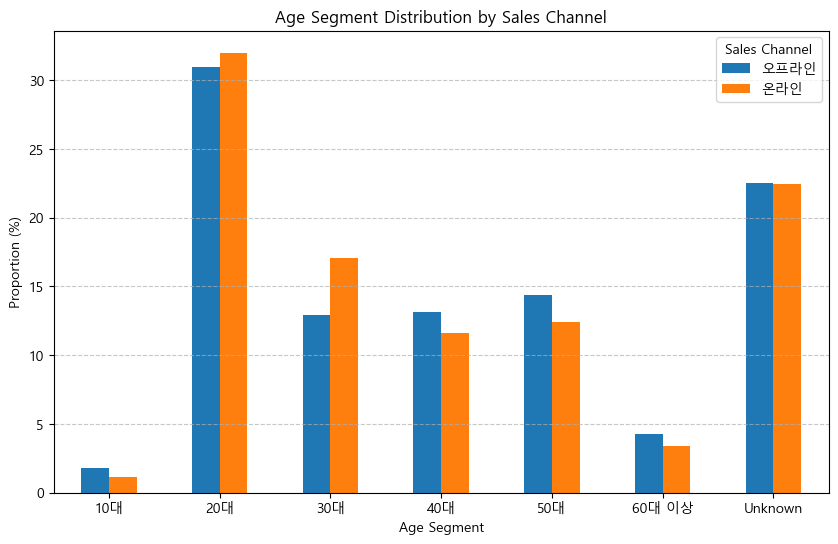

In [22]:
import matplotlib.pyplot as plt

# 1. 한글 폰트 설정 (Windows 기준 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 2. 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 시각화: 구매 경로별 연령대 분포 비교
channel_age_ratio.T.plot(kind='bar', figsize=(10, 6))

plt.title('Age Segment Distribution by Sales Channel')
plt.xlabel('Age Segment')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)
plt.legend(title='Sales Channel')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [23]:
# 사고법: 20대 데이터만 추출하여 구매 채널의 비율(normalize=True)을 계산한다.

# 1. 20대 데이터만 필터링
df_20s = final_df[final_df['age_segment'] == '20대']

# 2. 구매 경로별 비중 산출
channel_ratio_20s = df_20s['sales_channel_id'].value_counts(normalize=True) * 100

# 3. 결과 출력 (1: 오프라인, 2: 온라인)
print("### 20대 고객의 구매 채널 비중 ###")
print(f"오프라인(1) 구매 비중: {channel_ratio_20s.get(1, 0):.1f}%")
print(f"온라인(2) 구매 비중: {channel_ratio_20s.get(2, 0):.1f}%")

### 20대 고객의 구매 채널 비중 ###
오프라인(1) 구매 비중: 29.9%
온라인(2) 구매 비중: 70.1%


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 사고법: 각 연령대(10s ~ 60s+) 내에서 온라인(2)과 오프라인(1)의 비중이 어떻게 되는가?

# 1. 연령대별 구매 경로 교차표 생성 및 비율 변환
age_channel_ratio = pd.crosstab(final_df['age_segment'], 
                                final_df['sales_channel_id'], 
                                normalize='index') * 100

# 2. 컬럼명 이해하기 쉽게 변경 (1: Offline, 2: Online)
age_channel_ratio.columns = ['Offline', 'Online']

# 3. 결과 수치 확인
print("### 연령대별 온·오프라인 구매 비중 (%) ###")
print(age_channel_ratio.round(1))

### 연령대별 온·오프라인 구매 비중 (%) ###
             Offline  Online
age_segment                 
10대             42.1    57.9
20대             29.9    70.1
30대             25.0    75.0
40대             33.2    66.8
50대             33.9    66.1
60대 이상          35.9    64.1
Unknown         30.7    69.3


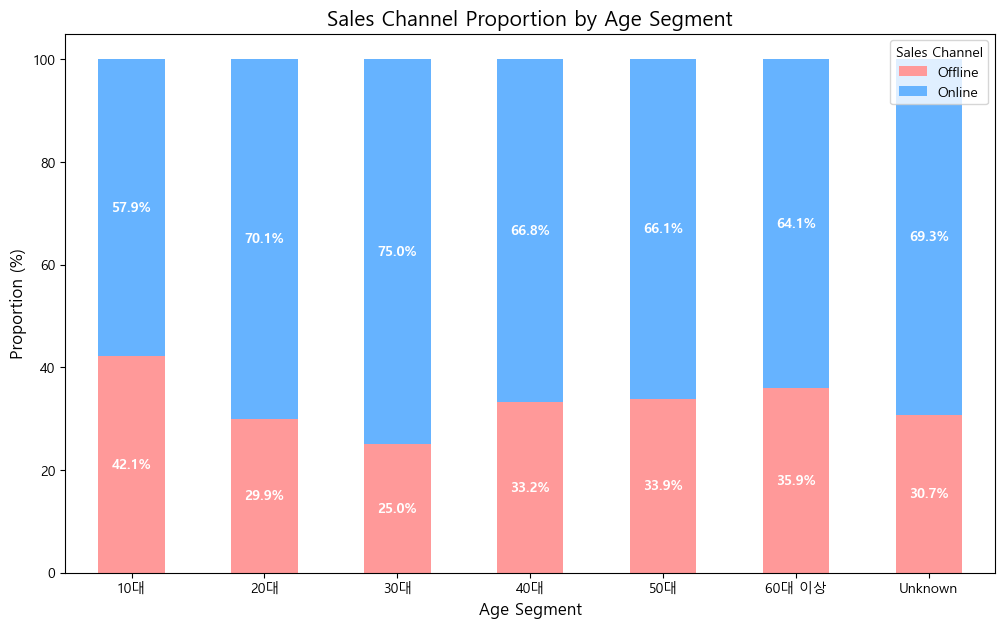

In [25]:
# 시각화 설정
age_channel_ratio.plot(kind='bar', stacked=True, figsize=(12, 7), color=['#ff9999', '#66b3ff'])

# 1. 한글 폰트 설정 (Windows 기준 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 2. 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

plt.title('Sales Channel Proportion by Age Segment', fontsize=15)
plt.xlabel('Age Segment', fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=0) # 연령대 글자를 가로로 바르게 표시
plt.legend(title='Sales Channel', loc='upper right')

# 비율 수치를 막대 위에 표시하고 싶다면 아래 반복문 추가 (선택사항)
for i, (off, on) in enumerate(zip(age_channel_ratio['Offline'], age_channel_ratio['Online'])):
    plt.text(i, off/2, f'{off:.1f}%', ha='center', va='center', color='white', fontweight='bold')
    plt.text(i, off + on/2, f'{on:.1f}%', ha='center', va='center', color='white', fontweight='bold')

plt.show()

In [26]:
# 사고법: 고객별로 구매 날짜를 정렬한 뒤 첫 번째 행(첫 구매)만 추출한다.
# 그 중 고객 상태가 '신규(PRE-CREATE, 매핑값 1)'인 데이터의 채널 비중을 구한다.

# 1. 날짜 데이터 형식 변환 (이미 되어 있다면 생략 가능)
final_df['t_dat'] = pd.to_datetime(final_df['t_dat'])

# 2. 고객별 첫 구매 기록만 추출 (날짜 기준 오름차순 정렬 후 첫 행)
first_purchase = final_df.sort_values(by=['customer_id', 't_dat']).drop_duplicates('customer_id', keep='first')

# 3. 신규 고객(매핑값 1) 데이터만 필터링
# (만약 'PRE-CREATE' 문자열 상태라면 해당 문자열로 필터링하세요)
new_customer_first = first_purchase[first_purchase['club_member_status'] == 1]

# 4. 첫 구매 채널 비중 계산
first_channel_ratio = new_customer_first['sales_channel_id'].value_counts(normalize=True) * 100

print("### 신규 고객의 첫 구매 채널 비중 ###")
print(f"오프라인(1) 유입: {first_channel_ratio.get(1, 0):.1f}%")
print(f"온라인(2) 유입: {first_channel_ratio.get(2, 0):.1f}%")

### 신규 고객의 첫 구매 채널 비중 ###
오프라인(1) 유입: 0.2%
온라인(2) 유입: 99.8%
